In [7]:
import math
import matplotlib.pyplot as plt
import pickle
from PIL import Image
import random
import torch
import torchvision.transforms as transforms


image2tensor = transforms.ToTensor()
tensor2image = transforms.ToPILImage()

In [2]:
num_patterns = 2
pattern_size = 3
num_cards = 2

output_image_path = 'data/images'
output_label_path = 'data/labels'

params = {'colors': ['red',
                     'orange',
                     'yellow',
                     'green',
                     'blue',
                     'indigo',
                     'violet',
                     'brown',
                     'black'],
          'max_sides': 5,
          'width': 10,
          'height': 10,
          'max_x_diff': 10,
          'max_y_diff': 10,
          'max_start_radius': 20,
          'max_radius_diff': 5}

In [3]:
x_min = (params['width'] - params['max_start_radius'] -
        (pattern_size - 1) * (params['max_x_diff'] + params['max_radius_diff']))

x_max = (params['width'] + params['max_start_radius'] +
        (pattern_size - 1) * (params['max_x_diff'] + params['max_radius_diff']))

y_min = (params['height'] - params['max_start_radius'] -
        (pattern_size - 1) * (params['max_y_diff'] + params['max_radius_diff']))

y_max = (params['height'] + params['max_start_radius'] +
        (pattern_size - 1) * (params['max_y_diff'] + params['max_radius_diff']))

In [4]:
def rand_seq(max_start, max_diff, length):
    start = max_start * random.random()
    diff = max_diff * random.random()
    return [start + j * diff for j in range(length)]

def generate_pattern(pattern_size, params):
    num_sides = [j for j in range(3, params['max_sides'] + 1)]
    
    colors = random.sample(params['colors'], pattern_size)
    sides = random.sample(num_sides, pattern_size)
    x_coords = rand_seq(params['width'], params['max_x_diff'], pattern_size)
    y_coords = rand_seq(params['height'], params['max_y_diff'], pattern_size)
    radii = rand_seq(params['max_start_radius'], params['max_radius_diff'], pattern_size)
    
    return zip(colors, sides, x_coords, y_coords, radii)

def show_patterns(num_patterns, pattern_size, params):  # TODO Y U NO FAST?!?!
    patterns = [generate_pattern(pattern_size, params)
                for _ in range(num_patterns)]
    while True:
        for data in random.choice(patterns):
            yield data

In [10]:
def make_regular_polygon(num_sides, x_center, y_center, size):
    points = []
    angle_offset = 0
    for k in range(num_sides):
        x = size * math.cos(angle_offset) + x_center
        y = size * math.sin(angle_offset) + y_center
        points.append([x, y])
        angle_offset += 2 * math.pi / num_sides
    points.append(points[0])
    return zip(*points)

def show_card(data, color, x_min, x_max, y_min, y_max, file_path=''):
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.fill(*data, color)
    if file_path:
        plt.savefig(file_path)
    plt.show()
    
def get_image(data, x_min, x_max, y_min, y_max):
    polygon_data = make_regular_polygon(*data[1:])
    show_card(polygon_data, data[0], x_min, x_max, y_min, y_max, 'tmp.png')
    image = Image.open('tmp.png')
    image_tensor = image2tensor(image)
    return image_tensor

def get_labels(data, colors):
    data = [colors.index(data[0])] + list(data[1:])
    return torch.tensor(data)

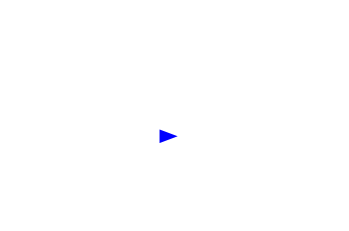

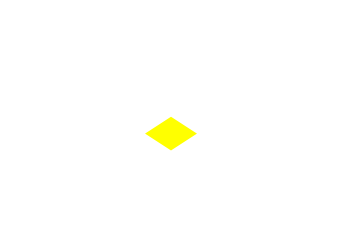

In [12]:
gen = show_patterns(num_patterns, pattern_size, params)
images = []
labels = []
for _ in range(num_cards):
    data = next(gen)
    images.append(get_image(data, x_min, x_max, y_min, y_max))
    labels.append(get_labels(data, params['colors']))
    
images = torch.stack(images)
labels = torch.stack(labels)

In [13]:
print(images.shape)
print(labels.shape)

torch.Size([2, 4, 288, 432])
torch.Size([2, 5])


In [14]:
with open(output_image_path, 'wb') as f:
    pickle.dump(images, f)

with open(output_label_path, 'wb') as f:
    pickle.dump(labels, f)